Customer Segmentation Based on Product Category Spending

In [135]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.stats import shapiro

## Dataset
The data used in this project can be found on Kaggle:  
[Wholesale Customers Data Set](https://www.kaggle.com/datasets/binovi/wholesale-customers-data-set)


Read Data

In [136]:
data = pd.read_csv("https://raw.githubusercontent.com/mhamadAlhajj/Wholesale-Product-Sales/main/Wholesale_Data.csv")


Data Overview

In [137]:
print(data.shape)
print(data.info())
print(data.describe())

(440, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None
          Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.00

    Shape: 
The dataset contains 440 rows and 8 columns.

    info :
All columns contain numeric data with no missing values

In [138]:
cols_to_check = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

normal_col = []
non_normal_col = []

for col in cols_to_check:
    stat , p = shapiro(data[col])
    if p > 0.05 :
        normal_col.append(col)
    else :
        non_normal_col.append(col)

print(f"Columns that have a normal distribution: {normal_col}")
print(f"Columns that do not have a normal distribution: {non_normal_col}")



Columns that have a normal distribution: []
Columns that do not have a normal distribution: ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']


All columns have a non-normal distribution.

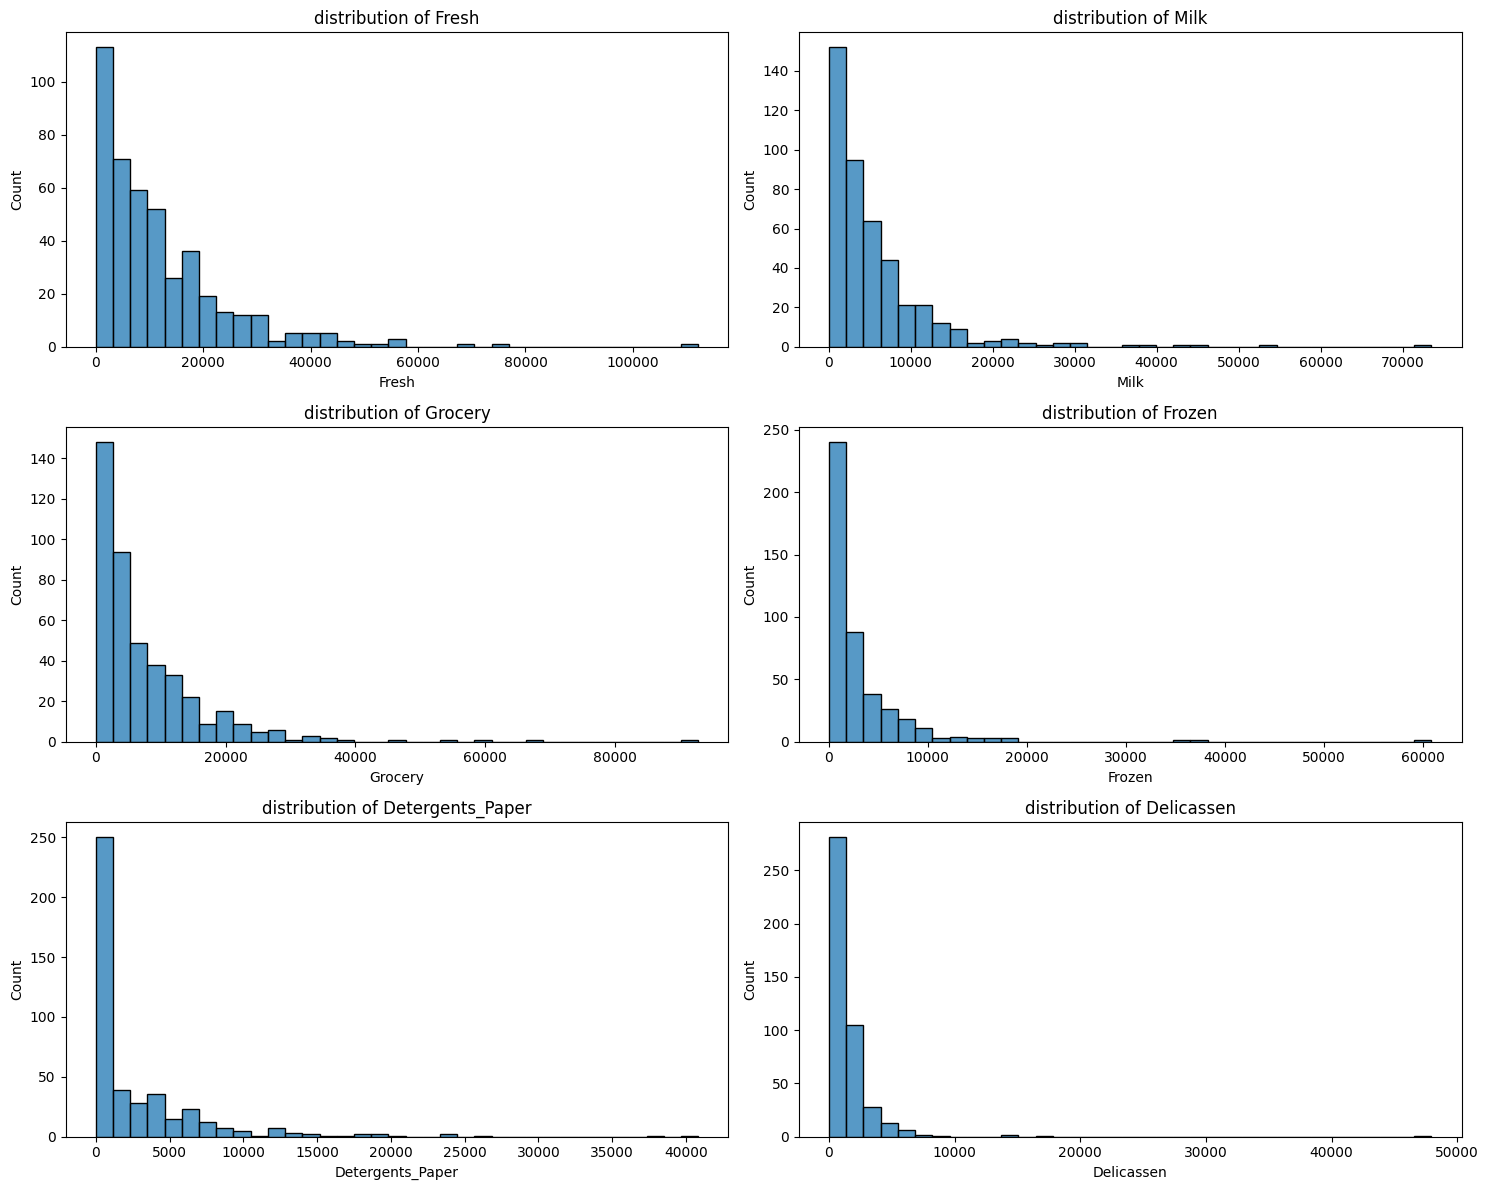

In [139]:
plt.figure(figsize=(15, 12))
nrows=int(np.ceil(len(cols_to_check)/2))
for index,column in enumerate(cols_to_check):
    plt.subplot(nrows,2,index+1)
    sns.histplot(data[column],bins=35)

    plt.title(f"distribution of {column}")
plt.tight_layout()
plt.show()

We can see that all columns are right-skewed.

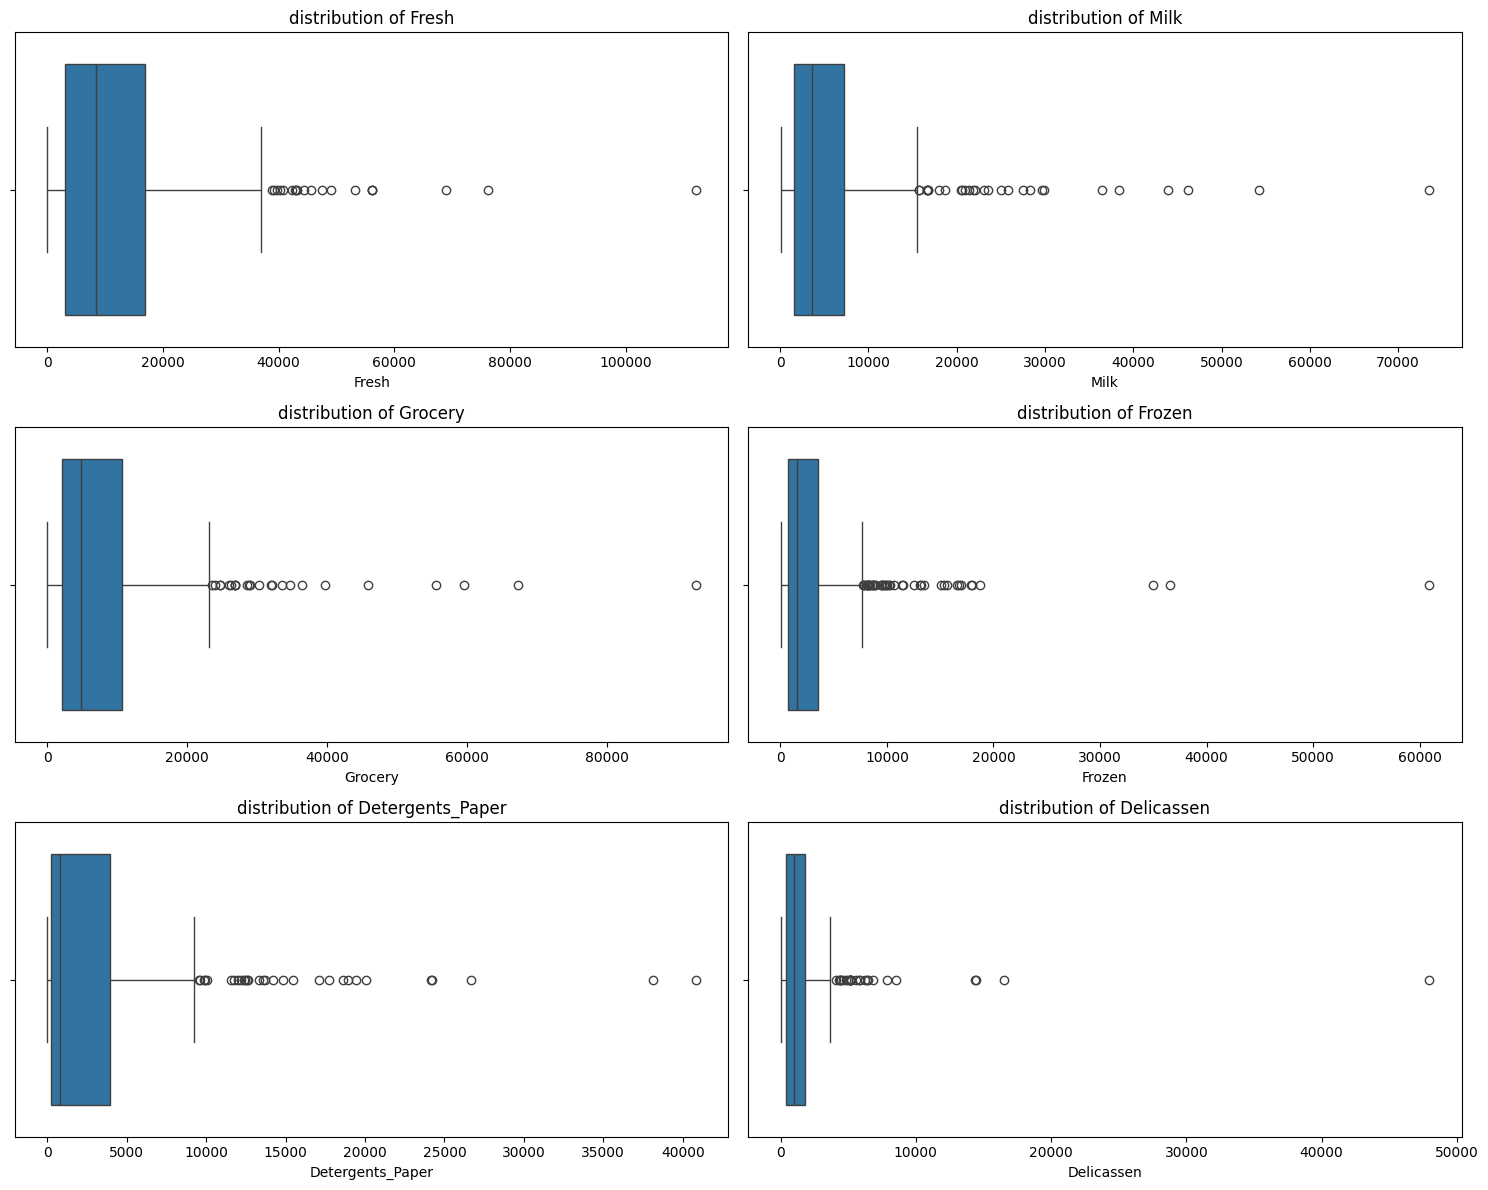

In [140]:
plt.figure(figsize=(15,12))
for index , column in enumerate(cols_to_check):
    plt.subplot(nrows,2,index+1)
    sns.boxplot(x=data[column])
    plt.title(f"distribution of {column}")
plt.tight_layout()
plt.show()

All the boxplots display some outliers . This indicates that there are a few customers with exceptionally high spending values in each category.

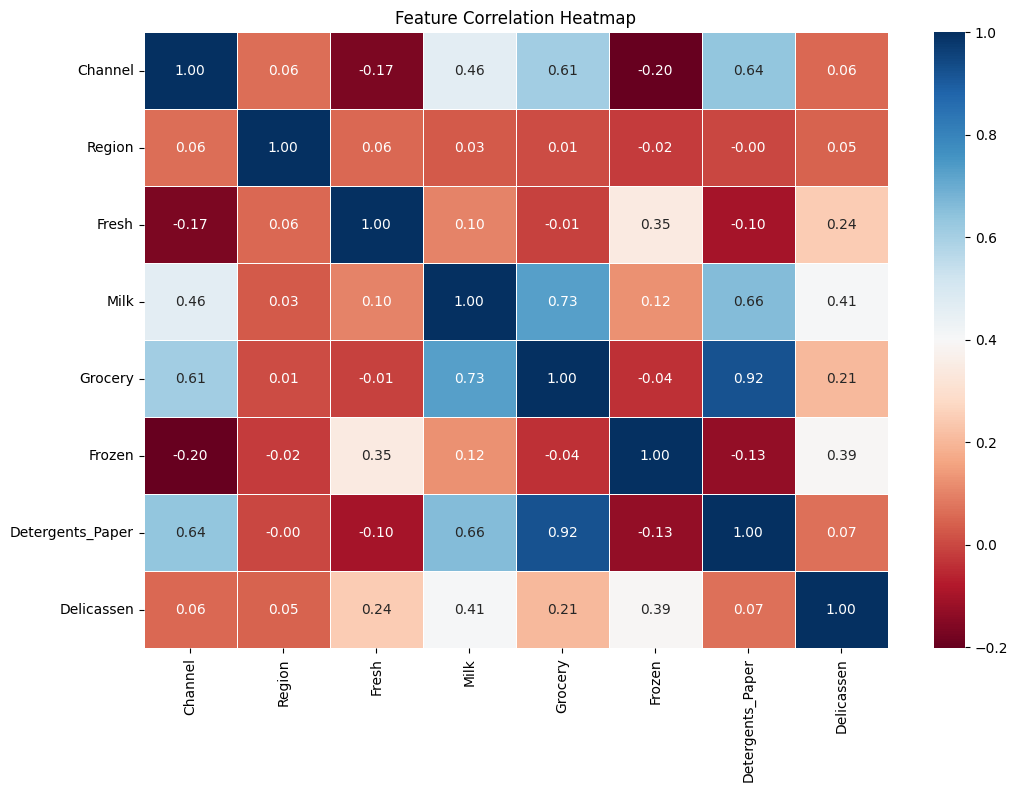

In [141]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(),cmap='RdBu',annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

Strongest positive correlation (0.92) exists between Grocery and Detergents_Paper.

Milk and Grocery show moderate positive correlation (0.73).

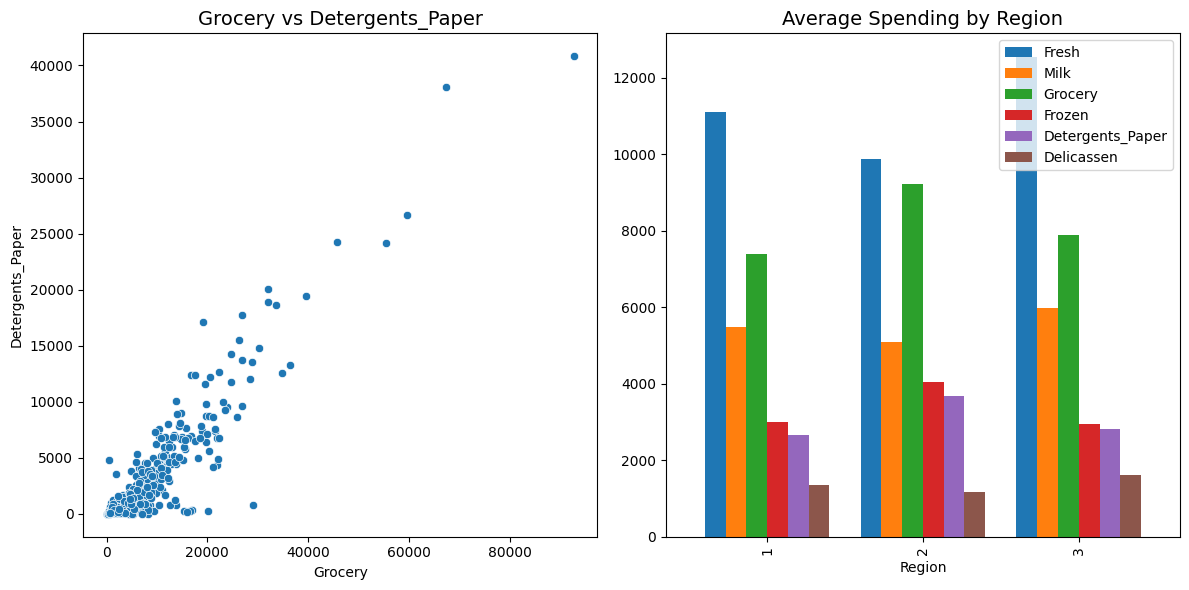

In [142]:
fig , axes = plt.subplots(1,2,figsize=(12,6))
sns.scatterplot(x="Grocery",y="Detergents_Paper",data=data,ax=axes[0])
axes[0].set_title("Grocery vs Detergents_Paper",fontsize=14)
axes[0].set_xlabel("Grocery")
axes[0].set_ylabel("Detergents_Paper")

avg_by_region=data.groupby("Region")[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].mean()
avg_by_region.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title("Average Spending by Region",fontsize=14)
plt.tight_layout()
plt.show()

    Scatter Plot of Grocery vs. Detergents_Paper:

There is a very strong positive relationship between grocery and detergents_paper; we already saw that through the heatmap.

    Bar Chart of Average Spending by Region:

Comparing the mean spending on each product category across different Regions.

In [143]:
for col in cols_to_check:        
    data[col]=np.log1p(data[col])

log1p helps reduce the impact of outliers.

In [144]:
scaler=MinMaxScaler()
scaled_data=scaler.fit_transform(data)


As we have already seen, none of the columns have a normal distribution, so we should use MinMaxScaler to scale them.

In [145]:
pca=PCA(n_components=2)
data_after_pca=pca.fit_transform(scaled_data)
print(pca.explained_variance_ratio_)

[0.51060619 0.29486822]


by using 2 components, we're capturing about 80% of the variance in the data.

In [147]:
Repsilon= np.arange(0.1, 2, 0.1)
RminS=range(2,11)
best_score = -1
best_eps = None
best_min_samples = None
for eps in Repsilon:
    for sam in RminS :
        dbscan=DBSCAN(eps=eps,min_samples=sam)
        dbscan.fit(data_after_pca)
        labels=dbscan.labels_
        if len(set(labels)) > 1 and -1 not in labels:
            score=silhouette_score(data_after_pca,labels)
            if score > best_score:
                best_eps=eps
                best_min_samples=sam
                best_score=score
if best_eps is not None:    
    print(f"best score {best_score}")
    print(f"best eps {best_eps}")
    print(f"best min samples {best_min_samples}")
else:
    print("No valid clustering found. Try adjusting DBSCAN parameters.")


best score 0.856050514889342
best eps 0.2
best min samples 2


So, we can see that the best epsilon is 0.2, and the best min samples is 2.

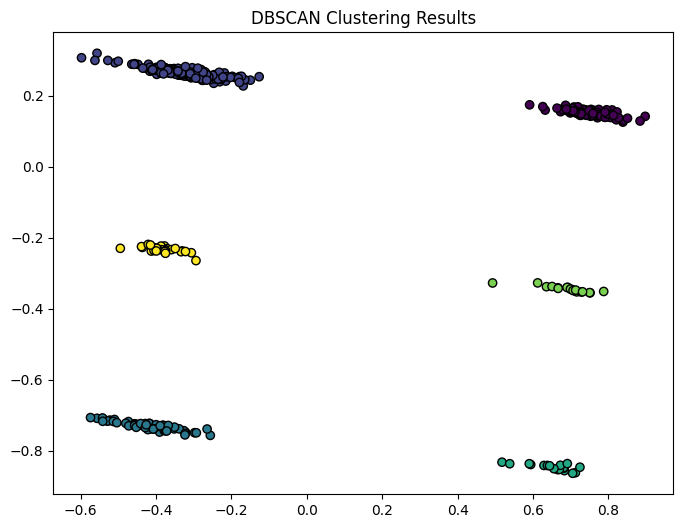

In [148]:
dbscan=DBSCAN(eps=best_eps,min_samples=best_min_samples)
dbscan.fit(data_after_pca)
labels=dbscan.labels_
score=silhouette_score(data_after_pca,labels)

plt.figure(figsize=(8,6))
plt.scatter(data_after_pca[:, 0], data_after_pca[:, 1], c=labels, cmap='viridis', edgecolors='k')
plt.title("DBSCAN Clustering Results")
plt.show()


dbscan split the points into 6 cluster 

In [149]:
K_range = range(2, 11)

best_score = -1
best_k = None

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_after_pca)
    labels = kmeans.labels_
    
    # Calculate silhouette score
    score = silhouette_score(data_after_pca, labels)
    
    if score > best_score:
        best_k = k
        best_score = score

# Output the results
if best_k is not None:
    print(f"Best silhouette score: {best_score}")
    print(f"Best k (number of clusters): {best_k}")
else:
    print("No valid clustering found. Try adjusting K-means parameters.")


Best silhouette score: 0.856050514889342
Best k (number of clusters): 6


Also, using KMeans, we can see that the best number of clusters is 6.

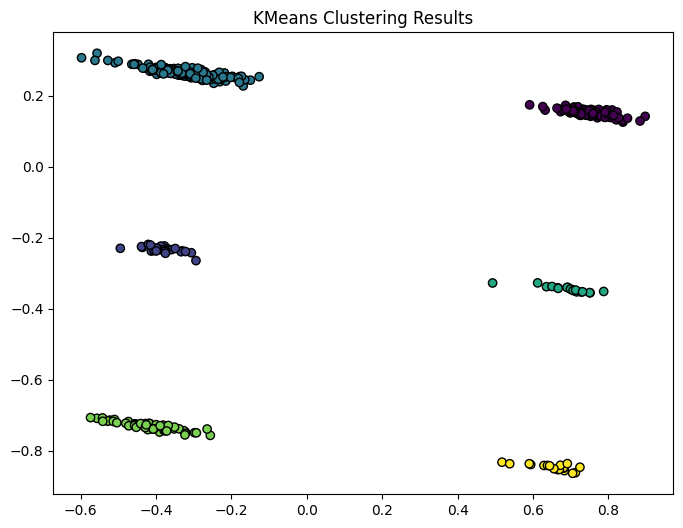

In [150]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(data_after_pca)
labels = kmeans.labels_
plt.figure(figsize=(8,6))
plt.scatter(data_after_pca[:, 0], data_after_pca[:, 1], c=labels, cmap='viridis', edgecolors='k')
plt.title("KMeans Clustering Results")
plt.show()